In [1]:
import pandas as pd
train=pd.read_csv(r"C:\Users\SAMSUNG\Desktop\공부파일들\데이콘\학습플랫폼갱신\train.csv")
test=pd.read_csv(r"C:\Users\SAMSUNG\Desktop\공부파일들\데이콘\학습플랫폼갱신\test.csv")

In [2]:
import sklearn.impute as skimp
import sklearn.pipeline as skpip
import sklearn.model_selection as skmod
import sklearn.compose as skcom
import sklearn.metrics as skmet
import sklearn.preprocessing as skpre
import sklearn.discriminant_analysis as skdis
import numpy as np
np.random.seed(10)
import scipy as sp

In [3]:
use_train=train.drop('user_id',axis=1)
num_cols=use_train.select_dtypes(np.number).columns.difference(["target"])
cate_cols=use_train.select_dtypes("object").columns
target="target"

# 우선 nan값이 없으므로
num_pip=skpip.make_pipeline(skpre.MinMaxScaler())
cate_pip=skpip.make_pipeline(skpre.OneHotEncoder(handle_unknown='ignore'))
column_trans=skcom.make_column_transformer((num_pip,num_cols),(cate_pip,cate_cols))

# 모델
LD_model=skdis.LinearDiscriminantAnalysis(store_covariance=True)

Total_process=skpip.make_pipeline(column_trans,LD_model)

### step 1. recall 과 precision 값의 trade off 관계를 보자

결정함수를 사용하여 각 샘플의 점수를 얻어보자

In [4]:
Total_process.fit(X=use_train,y=use_train[target])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['abandoned_learning_sessions', 'average_login_time',
       'average_time_per_learning_session', 'community_engagement_level',
       'customer_inquiry_history', 'monthly_active_learning_days',
       'payment_pattern', 'recent_learning_achievement', 'recent_login_time',
       'subscription_duration', 'total_completed_courses'],
      dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['preferred_difficulty_level', 'subscription_type'], dtype='object'))])),
                ('lineardiscriminantanalysis',
                 LinearDiscriminantAnalysis(store_covariance=True))])

In [9]:
Total_process.decision_function(X=use_train)

array([0.23757025, 0.67907656, 0.40104791, ..., 0.90630609, 0.2374775 ,
       0.28112228])

`cross_val_predict`에서 위의 score를 얻어보자

In [12]:
decision_score=skmod.cross_val_predict(estimator=Total_process,X=use_train,y=use_train[target],cv=3,n_jobs=-1,method='decision_function')

### step 2. 시각화

In [27]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams["font.family"]="Malgun Gothic"

In [15]:
precision,recall,therehold=skmet.precision_recall_curve(y_true=use_train[target],probas_pred=decision_score)

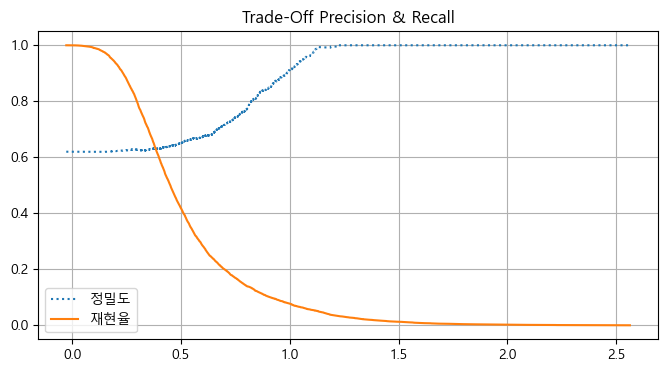

In [38]:
plt.figure(figsize=(8,4))
plt.title("Trade-Off Precision & Recall")
sb.lineplot(x=therehold,y=precision[:-1],label="정밀도",linestyle="dotted")
sb.lineplot(x=therehold,y=recall[:-1],label="재현율",linestyle="solid")
plt.grid()

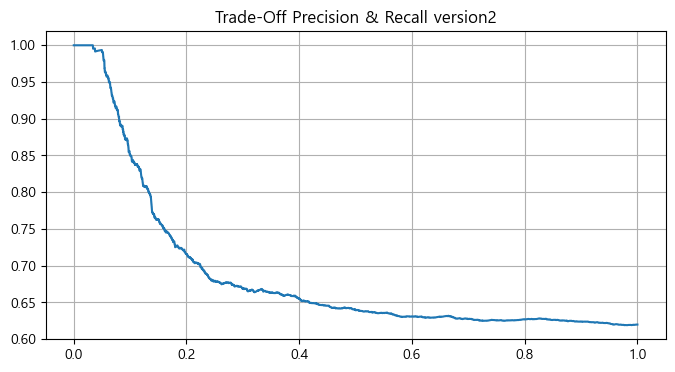

In [41]:
plt.figure(figsize=(8,4))
plt.title("Trade-Off Precision & Recall version2")
sb.lineplot(y=precision[:-1],x=recall[:-1],linestyle="solid")
plt.grid()

정밀도 80%를 달성해보자

In [58]:
idx_for_80_precision=(precision>=0.8).argmax()
idx_for_80_therehold=therehold[idx_for_80_precision]
idx_for_80_therehold

0.8236985042604876

In [60]:
# 다시 예측하기
y_pred_80=(decision_score>=idx_for_80_therehold)

In [61]:
# 점수측정 : 정밀도
skmet.precision_score(y_true=use_train[target],y_pred=y_pred_80)

0.8001930501930502

In [62]:
# 점수측정 : 재현율
skmet.recall_score(y_true=use_train[target],y_pred=y_pred_80)

0.1337312469753186